<a href="https://colab.research.google.com/github/medulka/LLMs/blob/main/Time_series_analysis_RNN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Head**

*Caputh, 23.09.2024, dva dny před prvním summitem AI & Data \
HD, po prvním rozhovoru s Bastianem a Sebastianem, Enari*

***modified after:***

https://github.com/Andrew-Ng-s-number-one-fan/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/master/Notebooks/C15_N1_Processing%20Sequences%20using%20RNNs%20and%20CNNs.ipynb
\
\
http://14.139.161.31/OddSem-0822-1122/Hands-On_Machine_Learning_with_Scikit-Learn-Keras-and-TensorFlow-2nd-Edition-Aurelien-Geron.pdf

# **Preparation**
\
**Common imports**

In [88]:
!python --version


Python 3.10.12


In [2]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.17.0'

In [3]:
import sklearn
print(sklearn.__version__)

1.5.2


In [4]:
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

**To stabilise the seed**



In [92]:
np.random.seed(42)
tf.random.set_seed(42)

**Preparation to plot the figures**

In [120]:
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# directory to save the pictures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "RNN"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGE_PATH,exist_ok = True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path=os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [98]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$'):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'bx', markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'ro')
    plt.grid(True)

    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)

    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

**Generate the dataset**

In [8]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size,1)
    time = np.linspace(0,1,n_steps)
    series = 0.5 * np.sin((time - offset1) * (freq1 * 10 * 10)) # wave 1
    series += 0.2 * np.sin((time - offset2) * (freq2 * 20 * 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 50

**Define the series**

In [95]:
series = generate_time_series(10000, n_steps = n_steps +1)

**Define the training dataset**

In [96]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
# X_train[1]
# y_train[1]
X_train.shape, y_train.shape


((7000, 50, 1), (7000, 1))

**Define the validation dataset**

In [97]:
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(2000, 50, 1) (2000, 1)
(1000, 50, 1) (1000, 1)


**Plot the series**

Saving figure time_series_plot


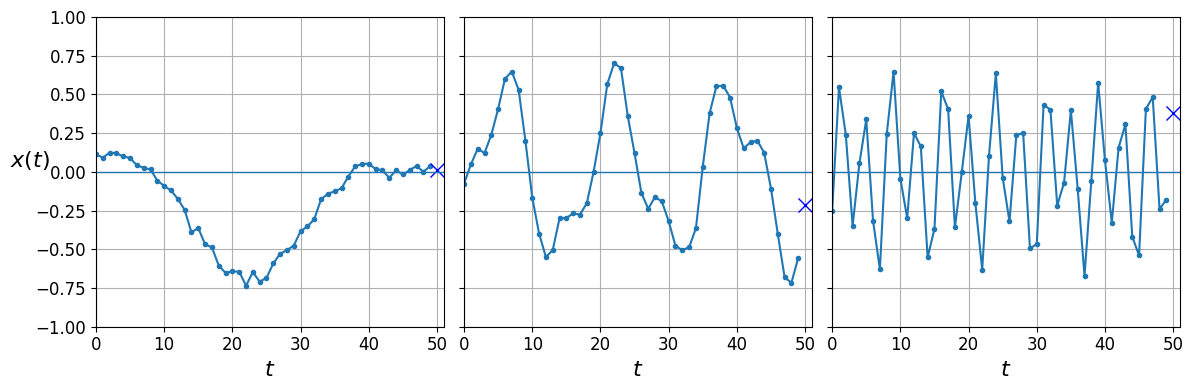

In [99]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize = (12,4))

for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$x(t)$' if col == 0 else None))

save_fig('time_series_plot')
plt.show()


# **Basic RNNs**

**Computing some baselines**

**1) Naive prediction** \
supposes that the next value ist the mean of the last three values

In [100]:
y_pred = X_valid[:, -1]
y_pred.shape


(2000, 1)

In [ ]:
# did not work out
# np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

In [101]:

def loss(predicted_y, desired_y):
    return tf.reduce_sum(tf.square(predicted_y - desired_y))

In [102]:
loss(y_pred, y_valid)

<tf.Tensor: shape=(), dtype=float32, numpy=329.4185>

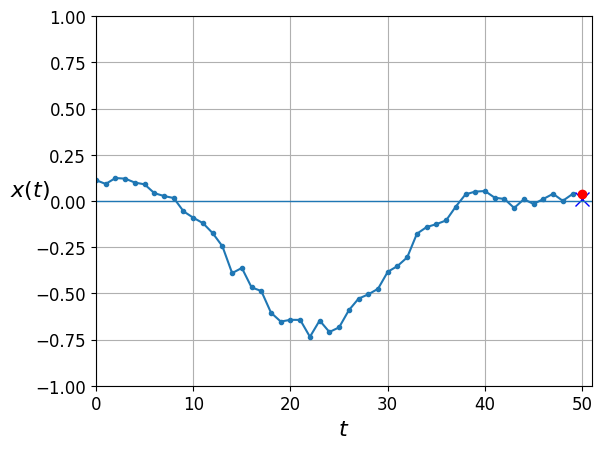

In [104]:
plot_series(X_valid[0, :, 0], y_valid[0,0], y_pred[0,0])

**2) Linear Prediction**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [110]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [50,1]),
    keras.layers.Dense(1)
])
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4184 - val_loss: 0.2195
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1862 - val_loss: 0.1338
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1240 - val_loss: 0.1107
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1060 - val_loss: 0.1015
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0979 - val_loss: 0.0962
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0928 - val_loss: 0.0926
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0895 - val_loss: 0.0902
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0872 - val_loss: 0.0886
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0857 - val_loss: 0.0875
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0847 - val_loss: 0.0868
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0840 - val_loss: 0.0863
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [128]:
print(history.history['val_loss'])

[0.21948817372322083, 0.1337965726852417, 0.11073395609855652, 0.1015269085764885, 0.09615175426006317, 0.09261772036552429, 0.09023342281579971, 0.08861449360847473, 0.08751615136861801, 0.08677469193935394, 0.08627741038799286, 0.08594615012407303, 0.08572667837142944, 0.08558198809623718, 0.08548695594072342, 0.08542479574680328, 0.0853843241930008, 0.0853581503033638, 0.08534135669469833, 0.08533076196908951]


In [111]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0878


0.08533076196908951

In [130]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5,
             loss, 'b.-', label='Training Loss')
    plt.plot(np.arange(len(val_loss)) + 1,
             val_loss, 'r.-', label='Validation Loss')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

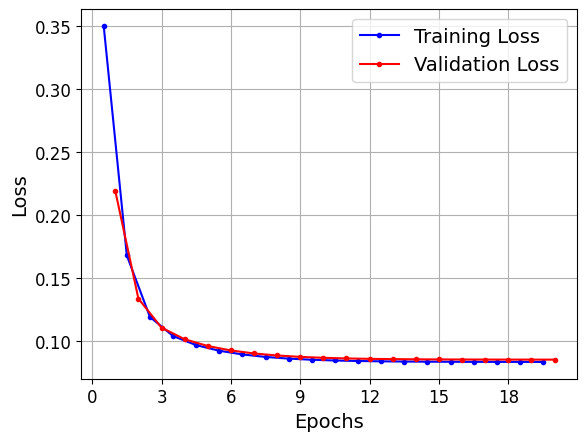

In [131]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])
plt.show()

**3) Using a simple RNN**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [132]:
model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape = [None, 1]) ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [134]:
optimiser = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss = 'mse', optimizer = optimiser, metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.0000e+00 - loss: 0.2402 - val_accuracy: 0.0000e+00 - val_loss: 0.1310
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.0000e+00 - loss: 0.1317 - val_accuracy: 0.0000e+00 - val_loss: 0.1247
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0000e+00 - loss: 0.1238 - val_accuracy: 0.0000e+00 - val_loss: 0.1111
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0000e+00 - loss: 0.1084 - val_accuracy: 0.0000e+00 - val_loss: 0.0957
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0960 - val_accuracy: 0.0000e+00 - val_loss: 0.0931
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0944 - val_accuracy: 0.0000e+00 - val_loss: 0.0930
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0943 - val_accuracy: 0.0000e+00 - val_loss: 0.0930
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [135]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0945


[0.09318014979362488, 0.0]

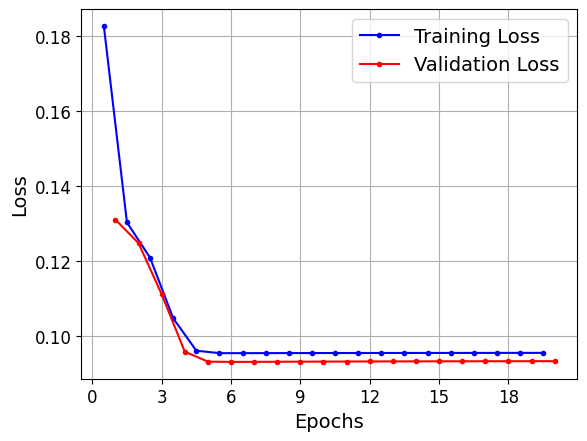

In [136]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


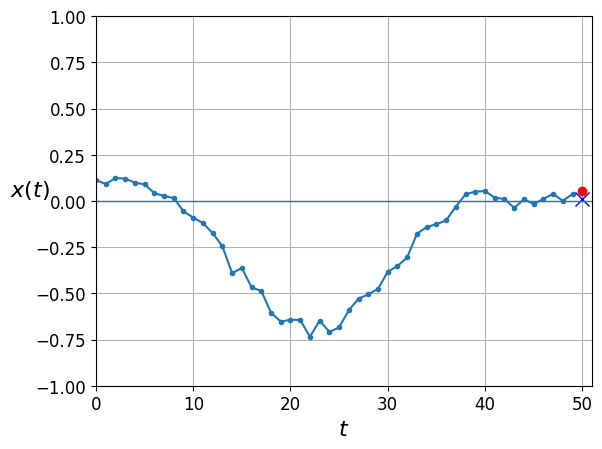

In [138]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])

**4) Using Deep RNN**

**4A) Simple RNN**

In [139]:
np.random.seed(42)
tf.random.set_seed(42)

In [140]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None,1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [141]:
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - loss: 0.1519 - val_loss: 0.0818
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0728 - val_loss: 0.0686
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0620 - val_loss: 0.0583
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - loss: 0.0532 - val_loss: 0.0512
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - loss: 0.0464 - val_loss: 0.0449
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0419 - val_loss: 0.0413
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0393 - val_loss: 0.0391
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - loss: 0.0377 - val_loss: 0.0374
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - loss: 0.0361 - val_loss: 0.0357
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0346 - val_loss: 0.0341
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0330 - val_loss: 0.0326
Epoch 12/20
219/219 ━━━━━━━━━━━━━

In [142]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0288


0.028076522052288055

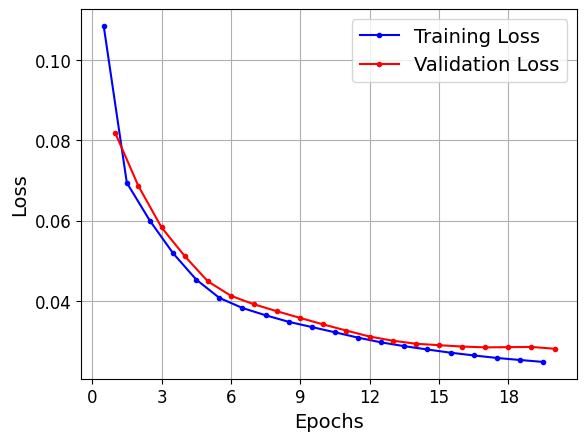

In [143]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


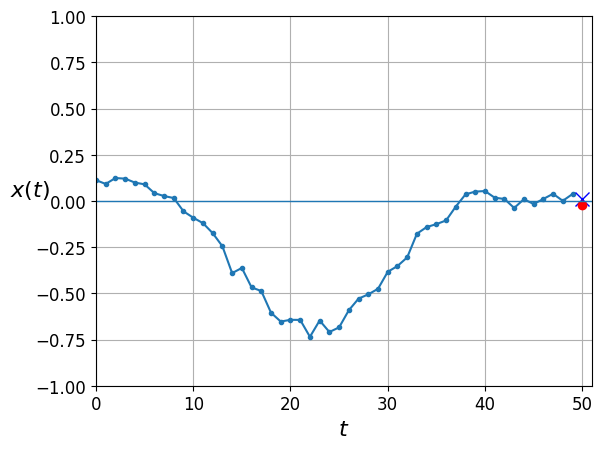

In [144]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])

**4B) Replacing the last layer to a dense layer**
\  
the second layer outputs only the last value

In [148]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [149]:
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.1593 - val_loss: 0.0711
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0604 - val_loss: 0.0497
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0445 - val_loss: 0.0415
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0390 - val_loss: 0.0389
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0365 - val_loss: 0.0372
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - loss: 0.0347 - val_loss: 0.0360
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0333 - val_loss: 0.0351
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0323 - val_loss: 0.0344
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 0.0313 - val_loss: 0.0338
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.0305 - val_loss: 0.0333
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0298 - val_loss: 0.0328
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━

In [150]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0285


0.02840914949774742

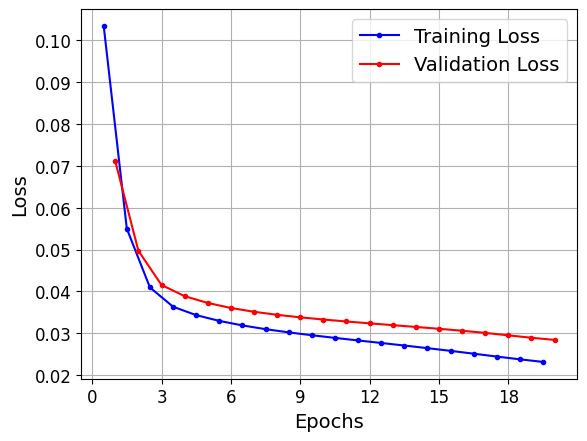

In [151]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


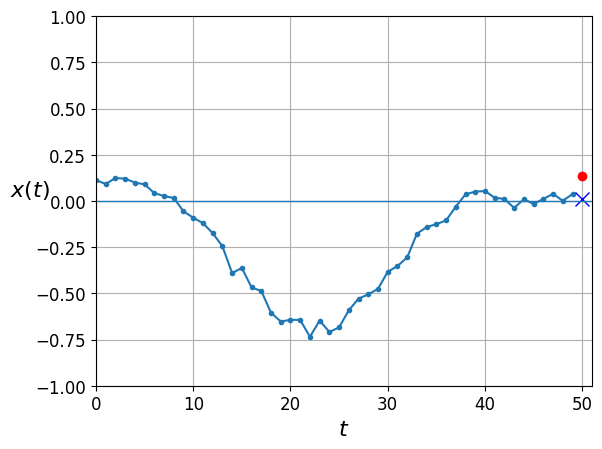

In [152]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0,0], y_pred[0,0])
plt.show()

# **Forecasting several steps ahead**

**5B) Predicting one data point**

In [10]:
np.random.seed(43) # not 42. It would give us the first series in the train set.

In [11]:
n_steps = 50

In [13]:
model = keras.models.Sequential([
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
keras.layers.SimpleRNN(20),
keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
series_2_pred_one_point = generate_time_series(1, n_steps + 10)
X_new, y_new = series_2_pred_one_point[:, :n_steps], series_2_pred_one_point[:, n_steps:]
X = X_new

for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead :])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps :]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [15]:
Y_pred.shape

(1, 10, 1)

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'ro-', label = 'Actual')
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 'bx-', label = 'Forecast', markersize = 10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to generate the sequences with 9 more time steps.

In [ ]:
np.random.seed(42)

n_steps = 50
series_3_pred_ten_points = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series_3_pred_ten_points[:, :, n_steps], series[:, n_steps :]
X = X_new

for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead :])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis =1 )

Y_pre = X[:, n_steps :]


In [ ]:
Y_pred.shape

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'ro-', label = 'Actual')
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, ;, 0], 'bx-', label = 'Forecast', markersize = 10)
    plt.axis([0, n_steps + ahead, -1,1])
    plt.legend(fontsize = 14)

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We fisrt need to regenerate the sequences with 9 more time steps.

In [ ]:
np.random.seed(42)

n_steps = 50
series_4_with_9_more_time_points = generate_time_series(10000, n_steps + 10) # not + 1, not + 9
X_train, Y_train = series_4_with_9_more_time_points[:7000, :n_steps], series_4_with_9_more_time_points[:7000, -10:, 0]
X_valid, Y_valid = series[7000:90000, :n_steps], sereis[7000:9000, -10:, 0]
X_test, Y_test = sereis[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [ ]:
X = X_valid

for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis = 1)

Y_pred = X[:, n_steps:, 0]


In [ ]:
Y_pred.shape

In [ ]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

Let's compare this performance with some baselines> naive predictions and a simple linear model:

In [ ]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))